In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from salishsea_tools import evaltools as et, viz_tools
import os
import datetime as dt
import gsw
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import matplotlib.dates as mdates
import cmocean as cmo
import scipy.interpolate as sinterp
import cmocean
import json
import f90nml
from collections import OrderedDict
from scipy.stats.mstats import gmean
import xarray as xr
import netCDF4 as nc
import gsw
import mocsy


fs=16
mpl.rc('xtick', labelsize=fs)
mpl.rc('ytick', labelsize=fs)
mpl.rc('legend', fontsize=fs)
mpl.rc('axes', titlesize=fs)
mpl.rc('axes', labelsize=fs)
mpl.rc('figure', titlesize=fs)
mpl.rc('font', size=fs)
mpl.rc('font', family='sans-serif', weight='normal', style='normal')

import warnings
#warnings.filterwarnings('ignore')
from IPython.display import Markdown, display



%matplotlib inline



In [2]:
f=xr.open_dataset('/results2/SalishSea/nowcast-green.202111/06apr21/SalishSea_1d_20210406_20210406_chem_T.nc')

In [3]:
f

<xarray.Dataset> Size: 287MB
Dimensions:                     (time_counter: 1, deptht: 40, y: 898, x: 398)
Coordinates:
  * time_counter                (time_counter) datetime64[ns] 8B 2021-04-06T1...
  * deptht                      (deptht) float32 160B 0.5 1.5 ... 414.5 441.5
  * y                           (y) int64 7kB 0 1 2 3 4 ... 893 894 895 896 897
  * x                           (x) int64 3kB 0 1 2 3 4 ... 393 394 395 396 397
Data variables:
    PAR                         (time_counter, deptht, y, x) float32 57MB ...
    turbidity                   (time_counter, deptht, y, x) float32 57MB ...
    dissolved_inorganic_carbon  (time_counter, deptht, y, x) float32 57MB ...
    total_alkalinity            (time_counter, deptht, y, x) float32 57MB ...
    dissolved_oxygen            (time_counter, deptht, y, x) float32 57MB ...
    CO2_flux                    (time_counter, y, x) float32 1MB ...
Attributes:
    name:         SalishSeaCast_1d_chem_T_20210406_20210406
    description:  Day-averaged chemistry variables resampled from v202111 Sal...
    history:      2023-01-27 19:06 -08:00: Generated by reshapr.api.v1.extrac...
    Conventions:  CF-1.6

### Puget Sound data from https://www.ncei.noaa.gov/data/oceans/ncei/ocads/metadata/0238424.html
##### Cite: Alin, Simone R.; Newton, Jan; Greeley, Dana; Curry, Beth; Herndon, Julian; Kozyr, Alex; Feely, Richard A. (2021). A compiled data product of profile, discrete biogeochemical measurements from 35 individual cruise datasets collected from a variety of ships in the southern Salish Sea and northern California Current System (Washington state marine waters) from 2008-02-04 to 2018-10-19 (NCEI Accession 0238424). [indicate subset used]. NOAA National Centers for Environmental Information. Dataset. https://doi.org/10.25921/zgk5-ep63. Accessed [date].

In [4]:
PS=pd.read_csv('/ocean/ksuchy/MOAD/analysis-karyn/notebooks/Evaluations/SalishCruise_dataProduct_2008to2018_09202023_allData.csv') ## Data from OCADS dataset

In [5]:
PS.keys()

Index(['record', 'EXPOCODE', 'CRUISE_ID', 'DATE_UTC', 'TIME_UTC', 'DATE_LOCAL',
       'TIME_LOCAL', 'LONGITUDE_DEC', 'LATITUDE_DEC', 'STATION_NO',
       'NISKIN_NO', 'MONTH_UTC', 'DAY_UTC', 'YEAR_UTC', 'CTDPRS_DBAR',
       'CTDTMP_DEG_C_ITS90', 'CTDTMP_FLAG_W', 'CTDSAL_PSS78', 'CTDSAL_FLAG_W',
       'SIGMATHETA_KG_M3', 'RECOMMENDED_OXYGEN_UMOL_KG',
       'RECOMMENDED_OXYGEN_MG_L', 'RECOMMENDED_OXYGEN_ML_L',
       'CTDOXY_UMOL_KG_ADJ', 'CTDOXY_UMOL_KG', 'CTDOXY_MG_L_1',
       'CTDOXY_MG_L_2', 'CTDOXY_FLAG_W', 'OXYGEN_UMOL_KG', 'OXYGEN_MG_L_1',
       'OXYGEN_MG_L_2', 'OXYGEN_MG_L_3', 'OXYGEN_FLAG_W', 'TA_UMOL_KG',
       'DIC_UMOL_KG', 'TA_FLAG_W', 'DIC_FLAG_W', 'NITRATE_UMOL_KG',
       'NITRATE_UMOL_L', 'NITRITE_UMOL_KG', 'NITRITE_UMOL_L',
       'AMMONIUM_UMOL_KG', 'AMMONIUM_UMOL_L', 'PHOSPHATE_UMOL_KG',
       'PHOSPHATE_UMOL_L', 'SILICATE_UMOL_KG', 'SILICATE_UMOL_L',
       'NUTRIENTS_FLAG_W'],
      dtype='object')

In [6]:
PS['DIC_UMOL_KG'].max()

2362.3

In [7]:
PS.rename(columns={'LONGITUDE_DEC':'Lon','LATITUDE_DEC':'Lat','DATE_UTC':'Date','TIME_UTC':'Time',\
                   'CRUISE_ID':'Cruise','CTDPRS_DBAR':'Z',\
                   'CTDTMP_DEG_C_ITS90':'Temp (degC)','STATION_NO':'Name','CTDSAL_PSS78':'Sal (PSS)'},inplace=True) 

In [8]:
PS=PS[~(PS['Lon'] < -124) & (PS['Lat'] < 50.0)] 

In [9]:
PS['Sal (g kg-1)']=gsw.conversions.SA_from_SP(PS['Sal (PSS)'],PS['Z'], PS['Lon'], PS['Lat']) ##absolute salinity

In [10]:
PS['Temp (CT degC)']=gsw.CT_from_t(PS['Sal (g kg-1)'], PS['Temp (degC)'], PS['Z']) ##conservative temp

In [11]:
PS['Sal (g kg-1)']

35      33.391446
36      32.943459
37      32.420453
38      31.944572
39      31.838209
          ...    
7478    30.627549
7479    30.398465
7480    30.330848
7481    30.325521
7482    30.326608
Name: Sal (g kg-1), Length: 6789, dtype: float64

In [12]:
## Calculation for density

PS_rho = gsw.density.rho((PS['Sal (g kg-1)']),(PS['Temp (CT degC)']),(PS['Z']))

In [13]:
PS_rho

35      1026.484721
36      1025.924800
37      1025.296787
38      1024.705536
39      1024.515535
           ...     
7478    1023.698912
7479    1023.482533
7480    1023.386020
7481    1023.349197
7482    1023.330636
Length: 6789, dtype: float64

In [15]:
PS.keys()

Index(['record', 'EXPOCODE', 'Cruise', 'Date', 'Time', 'DATE_LOCAL',
       'TIME_LOCAL', 'Lon', 'Lat', 'Name', 'NISKIN_NO', 'MONTH_UTC', 'DAY_UTC',
       'YEAR_UTC', 'Z', 'Temp (degC)', 'CTDTMP_FLAG_W', 'Sal (PSS)',
       'CTDSAL_FLAG_W', 'SIGMATHETA_KG_M3', 'RECOMMENDED_OXYGEN_UMOL_KG',
       'RECOMMENDED_OXYGEN_MG_L', 'RECOMMENDED_OXYGEN_ML_L',
       'CTDOXY_UMOL_KG_ADJ', 'CTDOXY_UMOL_KG', 'CTDOXY_MG_L_1',
       'CTDOXY_MG_L_2', 'CTDOXY_FLAG_W', 'OXYGEN_UMOL_KG', 'OXYGEN_MG_L_1',
       'OXYGEN_MG_L_2', 'OXYGEN_MG_L_3', 'OXYGEN_FLAG_W', 'TA_UMOL_KG',
       'DIC_UMOL_KG', 'TA_FLAG_W', 'DIC_FLAG_W', 'NITRATE_UMOL_KG',
       'NITRATE_UMOL_L', 'NITRITE_UMOL_KG', 'NITRITE_UMOL_L',
       'AMMONIUM_UMOL_KG', 'AMMONIUM_UMOL_L', 'PHOSPHATE_UMOL_KG',
       'PHOSPHATE_UMOL_L', 'SILICATE_UMOL_KG', 'SILICATE_UMOL_L',
       'NUTRIENTS_FLAG_W', 'Sal (g kg-1)', 'Temp (CT degC)'],
      dtype='object')

In [17]:
PS['DO (uM)']= PS['RECOMMENDED_OXYGEN_UMOL_KG'] *(PS_rho/1000)
PS['NO3 (uM)']= PS['NITRATE_UMOL_KG'] *(PS_rho/1000)
PS['NO2 (uM)']= PS['NITRITE_UMOL_KG'] *(PS_rho/1000)
PS['NH4 (uM)']= PS['AMMONIUM_UMOL_KG'] *(PS_rho/1000)
PS['PO4 (uM)']= PS['PHOSPHATE_UMOL_KG'] *(PS_rho/1000)
PS['SIO4 (uM)']= PS['SILICATE_UMOL_KG'] *(PS_rho/1000)
PS['TA (uM)']= PS['TA_UMOL_KG'] *(PS_rho/1000)
PS['DIC (uM)']= PS['DIC_UMOL_KG'] *(PS_rho/1000)

In [18]:
PS['DIC (uM)'].max()

2414.3701738868076

In [17]:
PS.keys()

Index(['record', 'EXPOCODE', 'Cruise', 'Date', 'Time', 'DATE_LOCAL',
       'TIME_LOCAL', 'Lon', 'Lat', 'Name', 'NISKIN_NO', 'MONTH_UTC', 'DAY_UTC',
       'YEAR_UTC', 'Z', 'Temp (degC)', 'CTDTMP_FLAG_W', 'Sal (PSS)',
       'CTDSAL_FLAG_W', 'SIGMATHETA_KG_M3', 'RECOMMENDED_OXYGEN_UMOL_KG',
       'RECOMMENDED_OXYGEN_MG_L', 'RECOMMENDED_OXYGEN_ML_L',
       'CTDOXY_UMOL_KG_ADJ', 'CTDOXY_UMOL_KG', 'CTDOXY_MG_L_1',
       'CTDOXY_MG_L_2', 'CTDOXY_FLAG_W', 'OXYGEN_UMOL_KG', 'OXYGEN_MG_L_1',
       'OXYGEN_MG_L_2', 'OXYGEN_MG_L_3', 'OXYGEN_FLAG_W', 'TA_UMOL_KG',
       'DIC_UMOL_KG', 'TA_FLAG_W', 'DIC_FLAG_W', 'NITRATE_UMOL_KG',
       'NITRATE_UMOL_L', 'NITRITE_UMOL_KG', 'NITRITE_UMOL_L',
       'AMMONIUM_UMOL_KG', 'AMMONIUM_UMOL_L', 'PHOSPHATE_UMOL_KG',
       'PHOSPHATE_UMOL_L', 'SILICATE_UMOL_KG', 'SILICATE_UMOL_L',
       'NUTRIENTS_FLAG_W', 'Sal (g kg-1)', 'Temp (CT degC)', 'DO (uM)',
       'NO3 (uM)', 'NO2 (uM)', 'NH4 (uM)', 'PO4 (uM)', 'SIO4 (uM)', 'TA (uM)',
       'DIC (uM)'],
 

In [18]:
 # Retain only selected variables following Parker MacCready https://github.com/parkermac/LO/blob/main/obs/nceiCoastal/process_data.py
cols = ['Cruise','Date', 'Time', 'Lat', 'Lon', 'PATH', 'Z',
        'Temp (degC)','Temp (CT degC)', 'Sal (g kg-1)','Sal (PSS)' ,'DO (uM)',
        'NO3 (uM)', 'NO2 (uM)', 'NH4 (uM)', 'PO4 (uM)', 'SiO4 (uM)',
        'TA (uM)', 'DIC (uM)','TA_FLAG_W', 'DIC_FLAG_W']
this_cols = [item for item in cols if item in PS.columns]
PS = PS[this_cols]

In [19]:
PS.keys()

Index(['Cruise', 'Date', 'Time', 'Lat', 'Lon', 'Z', 'Temp (degC)',
       'Temp (CT degC)', 'Sal (g kg-1)', 'Sal (PSS)', 'DO (uM)', 'NO3 (uM)',
       'NO2 (uM)', 'NH4 (uM)', 'PO4 (uM)', 'TA (uM)', 'DIC (uM)', 'TA_FLAG_W',
       'DIC_FLAG_W'],
      dtype='object')

In [20]:
PS

,Cruise,Date,Time,Lat,Lon,Z,Temp (degC),Temp (CT degC),Sal (g kg-1),Sal (PSS),DO (uM),NO3 (uM),NO2 (uM),NH4 (uM),PO4 (uM),TA (uM),DIC (uM),TA_FLAG_W,DIC_FLAG_W
35,AQ201610,2016-10-25,6:09:55,48.2240,-123.4811,141.608,8.3447,8.349652,33.391446,33.2297,106.035872,29.788587,0.287416,0.000000,2.545682,2285.776176,2263.398809,2,2
36,AQ201610,2016-10-25,6:11:19,48.2241,-123.4808,110.587,8.7967,8.812697,32.943459,32.7846,126.599120,28.787450,0.287259,0.000000,2.492997,2264.421219,2234.874585,2,2
37,AQ201610,2016-10-25,6:12:26,48.2242,-123.4806,80.753,9.3383,9.367434,32.420453,32.2648,149.795861,27.324159,0.307589,0.112783,2.419700,2235.146995,2199.159078,2,2
38,AQ201610,2016-10-25,6:13:34,48.2243,-123.4804,50.157,9.8490,9.891354,31.944572,31.7917,180.040763,25.463933,0.348400,0.399635,2.336329,2210.494783,2163.460798,2,2
39,AQ201610,2016-10-25,6:14:23,48.2243,-123.4802,30.641,9.9635,10.010329,31.838209,31.6858,183.798087,25.151856,0.358580,0.399561,2.335895,2203.528012,2154.965975,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7478,SH1604,2016-03-18,21:30:02,48.2472,-123.9837,29.953,9.1606,9.224768,30.627549,30.4809,260.940853,19.399094,0.286636,0.000000,1.678866,-1022.675213,-1022.675213,9,9
7479,SH1604,2016-03-18,21:30:37,48.2473,-123.9838,20.745,9.1351,9.203877,30.398465,30.2525,271.836961,17.655074,0.286575,0.173992,1.576163,2121.781639,2025.676629,2,2
7480,SH1604,2016-03-18,21:31:15,48.2473,-123.9840,11.556,9.1476,9.218510,30.330848,30.1851,287.571472,16.722128,0.276314,0.000000,1.524845,-1022.362634,-1022.362634,9,9
7481,SH1604,2016-03-18,21:31:53,48.2475,-123.9842,5.631,9.1844,9.256224,30.325521,30.1796,289.300818,16.660125,0.307005,0.102335,1.514557,-1022.325848,-1022.325848,9,9


In [21]:
## Code in this cell is based on Tereza's Dataset_dfmaker.ipynb notebook to keep everything consistent. Check with Debby and Susan about using DIC/TA masks and quality flagged. Will need to quality control Puget Sound data too?


PS_mask = (((PS['DIC_FLAG_W']==2) | (PS['DIC_FLAG_W']==6)) & \
        ((PS['TA_FLAG_W']==2) | (PS['TA_FLAG_W']==6)) & \
        (PS['DIC (uM)'] > 0) & (PS['TA (uM)'] >0))
print(np.shape(PS['DIC (uM)'][PS_mask]))

(3812,)


In [22]:
PS['DIC (uM)']=PS['DIC (uM)'][PS_mask]
PS['TA (uM)']=PS['TA (uM)'][PS_mask]

In [23]:
PS

,Cruise,Date,Time,Lat,Lon,Z,Temp (degC),Temp (CT degC),Sal (g kg-1),Sal (PSS),DO (uM),NO3 (uM),NO2 (uM),NH4 (uM),PO4 (uM),TA (uM),DIC (uM),TA_FLAG_W,DIC_FLAG_W
35,AQ201610,2016-10-25,6:09:55,48.2240,-123.4811,141.608,8.3447,8.349652,33.391446,33.2297,106.035872,29.788587,0.287416,0.000000,2.545682,2285.776176,2263.398809,2,2
36,AQ201610,2016-10-25,6:11:19,48.2241,-123.4808,110.587,8.7967,8.812697,32.943459,32.7846,126.599120,28.787450,0.287259,0.000000,2.492997,2264.421219,2234.874585,2,2
37,AQ201610,2016-10-25,6:12:26,48.2242,-123.4806,80.753,9.3383,9.367434,32.420453,32.2648,149.795861,27.324159,0.307589,0.112783,2.419700,2235.146995,2199.159078,2,2
38,AQ201610,2016-10-25,6:13:34,48.2243,-123.4804,50.157,9.8490,9.891354,31.944572,31.7917,180.040763,25.463933,0.348400,0.399635,2.336329,2210.494783,2163.460798,2,2
39,AQ201610,2016-10-25,6:14:23,48.2243,-123.4802,30.641,9.9635,10.010329,31.838209,31.6858,183.798087,25.151856,0.358580,0.399561,2.335895,2203.528012,2154.965975,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7478,SH1604,2016-03-18,21:30:02,48.2472,-123.9837,29.953,9.1606,9.224768,30.627549,30.4809,260.940853,19.399094,0.286636,0.000000,1.678866,NaN,NaN,9,9
7479,SH1604,2016-03-18,21:30:37,48.2473,-123.9838,20.745,9.1351,9.203877,30.398465,30.2525,271.836961,17.655074,0.286575,0.173992,1.576163,2121.781639,2025.676629,2,2
7480,SH1604,2016-03-18,21:31:15,48.2473,-123.9840,11.556,9.1476,9.218510,30.330848,30.1851,287.571472,16.722128,0.276314,0.000000,1.524845,NaN,NaN,9,9
7481,SH1604,2016-03-18,21:31:53,48.2475,-123.9842,5.631,9.1844,9.256224,30.325521,30.1796,289.300818,16.660125,0.307005,0.102335,1.514557,NaN,NaN,9,9


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


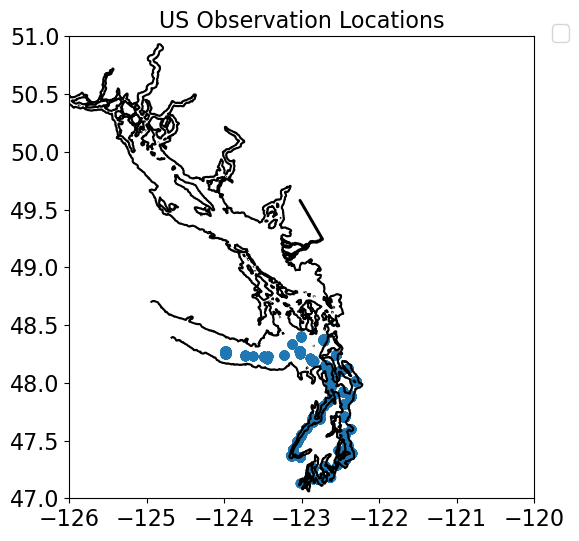

In [24]:
fig, ax = plt.subplots(1,1,figsize = (6,6))
with nc.Dataset('/ocean/ksuchy/MOAD/NEMO-forcing/grid/bathymetry_202108.nc') as grid:
    viz_tools.plot_coastline(ax, grid, coords = 'map',isobath=.1)
colors=('teal','green','firebrick','darkorange','darkviolet','fuchsia',
        'royalblue','darkgoldenrod','mediumspringgreen','deepskyblue','lightblue')
#datreg=dict()
#for ind, iregion in enumerate(data.region_name.unique()):
#    datreg[iregion] = data.loc[data.region_name==iregion]
ax.scatter(PS['Lon'], PS['Lat'],marker='o') #color = colors[ind]
ax.set_ylim(47,51)
ax.legend(bbox_to_anchor=[1,.6,0,0])
ax.set_xlim(-126, -120);
ax.set_title('US Observation Locations');
ax.legend(bbox_to_anchor=(1.1, 1.05))

In [25]:
SoG=pd.read_csv('/ocean/tjarniko/MEOPAR/analysis_tereza/notebooks/PI_CARBON_PAPER/MAIN_ANALYSIS/KEY_MODEVAL/Datasets/combined_fromdf.csv')
## data from Tereza Jarnikova's compiled dataset for Canadian waters of Salish Sea

In [26]:
SoG.keys()

Index(['Unnamed: 0', 'crid', 'ln', 'stn', 'mon', 'day', 'lat', 'lon', 'P', 'T',
       'S', 'dic', 'alk', 'dic_qf', 'alk_qf', 'OmegaA', 'obs_j', 'obs_i'],
      dtype='object')

In [27]:
SoG

,Unnamed: 0,crid,ln,stn,mon,day,lat,lon,P,T,S,dic,alk,dic_qf,alk_qf,OmegaA,obs_j,obs_i
0,0,2012.19,2.0,39.5,4.0,2.0,49.03,-123.43,311.8,8.545,30.828,2115.57,2156.27,2.0,2.0,7.895135e-01,422.0,264.0
1,1,2012.19,2.0,39.5,4.0,2.0,49.03,-123.43,312.2,8.545,30.828,NaN,NaN,9.0,9.0,1.000000e+20,422.0,264.0
2,2,2012.19,2.0,39.5,4.0,2.0,49.03,-123.43,251.3,8.323,30.726,2106.02,2131.55,2.0,2.0,7.007527e-01,422.0,264.0
3,3,2012.19,2.0,39.5,4.0,2.0,49.03,-123.43,251.3,8.323,30.725,NaN,NaN,9.0,9.0,1.000000e+20,422.0,264.0
4,4,2012.19,2.0,39.5,4.0,2.0,49.03,-123.43,201.1,7.875,30.567,2086.79,2124.90,2.0,2.0,7.769610e-01,422.0,264.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048,1048,2015.17,1.0,12.0,4.0,5.0,49.73,-124.68,175.6,9.317,30.481,NaN,NaN,9.0,9.0,1.000000e+20,647.0,168.0
1049,1049,2015.17,1.0,12.0,4.0,5.0,49.73,-124.68,200.7,9.438,30.608,2101.95,2087.77,2.0,2.0,5.073705e-01,647.0,168.0
1050,1050,2015.17,1.0,12.0,4.0,5.0,49.73,-124.68,251.0,9.384,30.736,2115.35,2126.71,2.0,2.0,6.302982e-01,647.0,168.0
1051,1051,2015.17,1.0,12.0,4.0,5.0,49.73,-124.68,300.8,9.361,30.800,NaN,NaN,9.0,9.0,1.000000e+20,647.0,168.0


In [28]:
SoG.crid

0       2012.19
1       2012.19
2       2012.19
3       2012.19
4       2012.19
         ...   
1048    2015.17
1049    2015.17
1050    2015.17
1051    2015.17
1052    2015.17
Name: crid, Length: 1053, dtype: float64

In [29]:
SoG['Year']=SoG['crid'].astype(str).str[:4]
SoG['mon']=SoG['mon'].astype(str).str[:1]
SoG['day']=SoG['day'].astype(str).str[:1]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


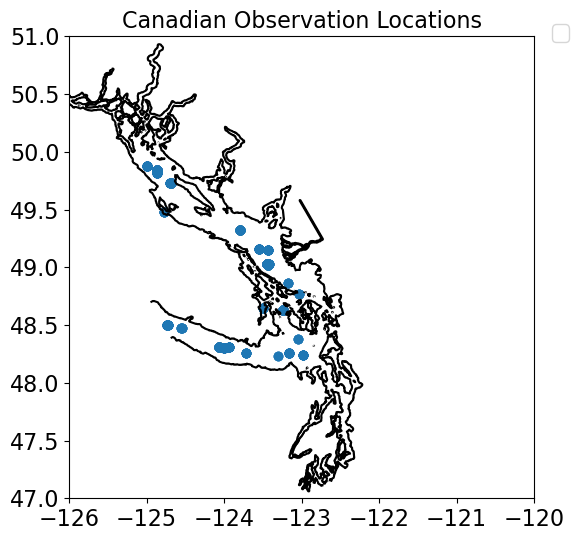

In [30]:
fig, ax = plt.subplots(1,1,figsize = (6,6))
with nc.Dataset('/ocean/ksuchy/MOAD/NEMO-forcing/grid/bathymetry_202108.nc') as grid:
    viz_tools.plot_coastline(ax, grid, coords = 'map',isobath=.1)
colors=('teal','green','firebrick','darkorange','darkviolet','fuchsia',
        'royalblue','darkgoldenrod','mediumspringgreen','deepskyblue','lightblue')
#datreg=dict()
#for ind, iregion in enumerate(data.region_name.unique()):
#    datreg[iregion] = data.loc[data.region_name==iregion]
ax.scatter(SoG['lon'], SoG['lat'],marker='o') #color = colors[ind]
ax.set_ylim(47,51)
ax.legend(bbox_to_anchor=[1,.6,0,0])
ax.set_xlim(-126, -120);
ax.set_title('Canadian Observation Locations');
ax.legend(bbox_to_anchor=(1.1, 1.05))

In [31]:
### Combine three columns of date information into a single time column
SoG['time'] = SoG.apply(lambda r: dt.datetime.strptime(f"{r['Year']} {r['mon']} {r['day']} {0}:{0}:{0}", '%Y %m %d %H:%M:%S'), axis=1)

In [32]:
SoG.keys()

Index(['Unnamed: 0', 'crid', 'ln', 'stn', 'mon', 'day', 'lat', 'lon', 'P', 'T',
       'S', 'dic', 'alk', 'dic_qf', 'alk_qf', 'OmegaA', 'obs_j', 'obs_i',
       'Year', 'time'],
      dtype='object')

In [33]:
PS.keys()

Index(['Cruise', 'Date', 'Time', 'Lat', 'Lon', 'Z', 'Temp (degC)',
       'Temp (CT degC)', 'Sal (g kg-1)', 'Sal (PSS)', 'DO (uM)', 'NO3 (uM)',
       'NO2 (uM)', 'NH4 (uM)', 'PO4 (uM)', 'TA (uM)', 'DIC (uM)', 'TA_FLAG_W',
       'DIC_FLAG_W'],
      dtype='object')

In [34]:
SoG.rename(columns={'lat':'Lat','lon':'Lon','time':'dtUTC','P':'Z',\
                   'T':'Temp (degC)','S':'Sal (PSS)'},inplace=True)

In [35]:
SoG['Sal (g kg-1)']=gsw.conversions.SA_from_SP(SoG['Sal (PSS)'],SoG['Z'], SoG['Lon'], SoG['Lat']) ##absolute salinity

In [36]:
SoG['Temp (CT degC)']=gsw.CT_from_t(SoG['Sal (g kg-1)'], SoG['Temp (degC)'], SoG['Z']) ##conservative temp

In [37]:
SoG_rho = gsw.density.rho((SoG['Sal (g kg-1)']),(SoG['Temp (CT degC)']),(SoG['Z'])) ## check to make sure this is the correct density formula (from teos-10)

## used the same equation as Parkers process_data.py file

In [38]:
SoG['DIC (uM)']=SoG['dic']*(SoG_rho/1000)
SoG['TA (uM)']=SoG['alk']*(SoG_rho/1000)

In [39]:
## Code in this cell is based on Tereza's Dataset_dfmaker.ipynb notebook to keep everything consistent. Check with Debby and Susan about using DIC/TA masks and quality flagged. Will need to quality control Puget Sound data too?


SoG_mask = (((SoG['dic_qf']==2) | (SoG['dic_qf']==6)) & \
        ((SoG['alk_qf']==2) | (SoG['alk_qf']==6)) & \
        (SoG['dic'] > 0) & (SoG['alk'] >0))
print(np.shape(SoG['dic'][SoG_mask]))

(572,)


In [40]:
SoG['DIC (uM)']=SoG['dic'][SoG_mask]
SoG['TA (uM)']=SoG['alk'][SoG_mask]

In [41]:
SoG['TA (uM)'].count()

572

In [42]:
PS['TA (uM)'].count()

3812

In [44]:
SoG['TA (uM)'].groupby(SoG['Year']).count()

Year
2003     59
2010     89
2011    107
2012    170
2014     72
2015     75
Name: TA (uM), dtype: int64

In [45]:
SoG.keys()

Index(['Unnamed: 0', 'crid', 'ln', 'stn', 'mon', 'day', 'Lat', 'Lon', 'Z',
       'Temp (degC)', 'Sal (PSS)', 'dic', 'alk', 'dic_qf', 'alk_qf', 'OmegaA',
       'obs_j', 'obs_i', 'Year', 'dtUTC', 'Sal (g kg-1)', 'Temp (CT degC)',
       'DIC (uM)', 'TA (uM)'],
      dtype='object')

In [46]:
PS.keys()

Index(['Cruise', 'Date', 'Time', 'Lat', 'Lon', 'Z', 'Temp (degC)',
       'Temp (CT degC)', 'Sal (g kg-1)', 'Sal (PSS)', 'DO (uM)', 'NO3 (uM)',
       'NO2 (uM)', 'NH4 (uM)', 'PO4 (uM)', 'TA (uM)', 'DIC (uM)', 'TA_FLAG_W',
       'DIC_FLAG_W'],
      dtype='object')

In [47]:
PS.rename(columns={'Date':'dtUTC','TA_FLAG_W':'TA_FLAG','DIC_FLAG_W':'DIC_FLAG'},inplace=True)

In [48]:
SoG.rename(columns={'alk_qf':'TA_FLAG','dic_qf':'DIC_FLAG'},inplace=True)

In [49]:
PS['dtUTC']=pd.to_datetime(PS.dtUTC).dt.tz_localize(None)

In [50]:
SoG.keys()

Index(['Unnamed: 0', 'crid', 'ln', 'stn', 'mon', 'day', 'Lat', 'Lon', 'Z',
       'Temp (degC)', 'Sal (PSS)', 'dic', 'alk', 'DIC_FLAG', 'TA_FLAG',
       'OmegaA', 'obs_j', 'obs_i', 'Year', 'dtUTC', 'Sal (g kg-1)',
       'Temp (CT degC)', 'DIC (uM)', 'TA (uM)'],
      dtype='object')

In [51]:
PS.keys()

Index(['Cruise', 'dtUTC', 'Time', 'Lat', 'Lon', 'Z', 'Temp (degC)',
       'Temp (CT degC)', 'Sal (g kg-1)', 'Sal (PSS)', 'DO (uM)', 'NO3 (uM)',
       'NO2 (uM)', 'NH4 (uM)', 'PO4 (uM)', 'TA (uM)', 'DIC (uM)', 'TA_FLAG',
       'DIC_FLAG'],
      dtype='object')

In [52]:
## create data df by combining Becca and Tereza's datasets
data=pd.concat([PS, SoG], axis=0, join='outer')

In [53]:
data.keys()

Index(['Cruise', 'dtUTC', 'Time', 'Lat', 'Lon', 'Z', 'Temp (degC)',
       'Temp (CT degC)', 'Sal (g kg-1)', 'Sal (PSS)', 'DO (uM)', 'NO3 (uM)',
       'NO2 (uM)', 'NH4 (uM)', 'PO4 (uM)', 'TA (uM)', 'DIC (uM)', 'TA_FLAG',
       'DIC_FLAG', 'Unnamed: 0', 'crid', 'ln', 'stn', 'mon', 'day', 'dic',
       'alk', 'OmegaA', 'obs_j', 'obs_i', 'Year'],
      dtype='object')

In [54]:
data['dtUTC']=pd.to_datetime(data['dtUTC']) 

In [55]:
data['dtUTC']

35     2016-10-25
36     2016-10-25
37     2016-10-25
38     2016-10-25
39     2016-10-25
          ...    
1048   2015-04-05
1049   2015-04-05
1050   2015-04-05
1051   2015-04-05
1052   2015-04-05
Name: dtUTC, Length: 7842, dtype: datetime64[ns]

In [56]:
data['Year']=[ii.year for ii in data['dtUTC']]
data['Month']=[ii.month for ii in data['dtUTC']]
#data['YD']=et.datetimeToYD(data['time'])

In [57]:
data['Year']

35      2016
36      2016
37      2016
38      2016
39      2016
        ... 
1048    2015
1049    2015
1050    2015
1051    2015
1052    2015
Name: Year, Length: 7842, dtype: int64

In [58]:
data['YMO']=pd.to_datetime(data[['Year', 'Month']].assign(DAY=1))

In [59]:
data=data[(data['Year'] >= 2007) & (data['Year'] <= 2024)] ##Select data only from 2007-2024

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


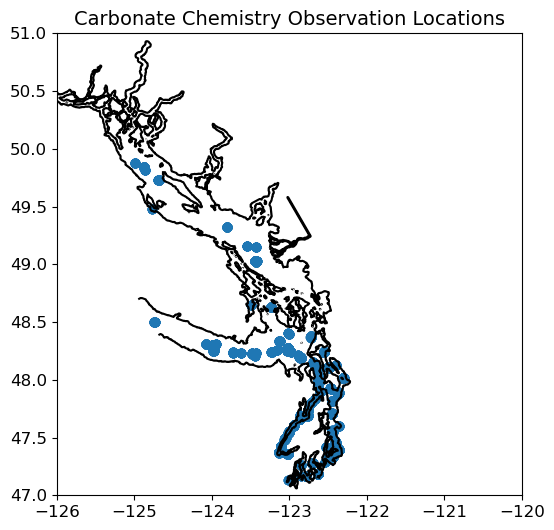

In [68]:
fig, ax = plt.subplots(1,1,figsize = (6,6))
with nc.Dataset('/ocean/ksuchy/MOAD/NEMO-forcing/grid/bathymetry_202108.nc') as grid:
    viz_tools.plot_coastline(ax, grid, coords = 'map',isobath=.1)
colors=('teal','green','firebrick','darkorange','darkviolet','fuchsia',
        'royalblue','darkgoldenrod','mediumspringgreen','deepskyblue','lightblue')
#datreg=dict()
#for ind, iregion in enumerate(data.region_name.unique()):
#    datreg[iregion] = data.loc[data.region_name==iregion]
ax.scatter(data['Lon'], data['Lat'],marker='o') #color = colors[ind]
ax.set_ylim(47,51)
plt.yticks(fontsize=12)
ax.legend(bbox_to_anchor=[1,.6,0,0])
ax.set_xlim(-126, -120)
plt.xticks(fontsize=12);
ax.set_title('Carbonate Chemistry Observation Locations',fontsize=14);
ax.legend(frameon=False)

In [57]:
data.keys()

Index(['Cruise', 'dtUTC', 'Time', 'Lat', 'Lon', 'Z', 'Temp (degC)',
       'Temp (CT degC)', 'Sal (g kg-1)', 'Sal (PSS)', 'DO (uM)', 'NO3 (uM)',
       'NO2 (uM)', 'NH4 (uM)', 'PO4 (uM)', 'TA (uM)', 'DIC (uM)', 'TA_FLAG',
       'DIC_FLAG', 'Unnamed: 0', 'crid', 'ln', 'stn', 'mon', 'day', 'dic',
       'alk', 'OmegaA', 'obs_j', 'obs_i', 'Year', 'Month', 'YMO'],
      dtype='object')

In [58]:
data.dtUTC

35     2016-10-25
36     2016-10-25
37     2016-10-25
38     2016-10-25
39     2016-10-25
          ...    
1048   2015-04-05
1049   2015-04-05
1050   2015-04-05
1051   2015-04-05
1052   2015-04-05
Name: dtUTC, Length: 7779, dtype: datetime64[ns]

In [59]:
data.dtUTC.max()

Timestamp('2018-10-19 00:00:00')

In [60]:
data.dtUTC.min()

Timestamp('2008-02-04 00:00:00')

In [61]:
#data.rename(columns={'Sal (g kg-1)':'Salinity'},inplace=True)

In [62]:
import netCDF4 as nc

In [63]:
f.keys()

KeysView(<xarray.Dataset> Size: 287MB
Dimensions:                     (time_counter: 1, deptht: 40, y: 898, x: 398)
Coordinates:
  * time_counter                (time_counter) datetime64[ns] 8B 2021-04-06T1...
  * deptht                      (deptht) float32 160B 0.5 1.5 ... 414.5 441.5
  * y                           (y) int64 7kB 0 1 2 3 4 ... 893 894 895 896 897
  * x                           (x) int64 3kB 0 1 2 3 4 ... 393 394 395 396 397
Data variables:
    PAR                         (time_counter, deptht, y, x) float32 57MB ...
    turbidity                   (time_counter, deptht, y, x) float32 57MB ...
    dissolved_inorganic_carbon  (time_counter, deptht, y, x) float32 57MB ...
    total_alkalinity            (time_counter, deptht, y, x) float32 57MB ...
    dissolved_oxygen            (time_counter, deptht, y, x) float32 57MB ...
    CO2_flux                    (time_counter, y, x) float32 1MB ...
Attributes:
    name:         SalishSeaCast_1d_chem_T_20210406_20210406
    d

In [64]:
PATH= '/results2/SalishSea/nowcast-green.202111/'

In [65]:
def matchData(
    data,
    filemap,
    fdict,
    mod_start=None,
    mod_end=None,
    mod_nam_fmt='nowcast',
    mod_basedir='/results2/SalishSea/nowcast-green.202111/',
    mod_flen=1,
    method='bin',
    meshPath=None,
    maskname='tmask',
    wrapSearch=False,
    fastSearch=False,
    wrapTol=1,
    e3tvar='e3t',
    fid=None,
    sdim=3,
    quiet=False,
    preIndexed=False
    ):
    """Given a discrete sample dataset, find match model output

    note: only one grid mask is loaded so all model variables must be on same grid; defaults to tmask;
        call multiple times for different grids (eg U,W)

    :arg data: pandas dataframe containing data to compare to. Must include the following:
        'dtUTC': column with UTC date and time
        'Lat': decimal latitude
        'Lon': decimal longitude
        'Z': depth, positive     NOT  required if method='ferry' or sdim=2
    :type :py:class:`pandas.DataFrame`

    :arg dict filemap: dictionary mapping names of model variables to filetypes containing them

    :arg dict fdict: dictionary mapping filetypes to their time resolution in hours

    :arg mod_start: first date of time range to match
    :type :py:class:`datetime.datetime`

    :arg mod_end: end of date range to match (not included)
    :type :py:class:`datetime.datetime`

    :arg str mod_nam_fmt: naming format for model files. options are 'nowcast' or 'long'
        'nowcast' example: 05may15/SalishSea_1h_20150505_20150505_ptrc_T.nc
        'long' example: SalishSea_1h_20150206_20150804_ptrc_T_20150427-20150506.nc
                    'long' will recursively search subdirectories (to match Vicky's storage style)

    :arg str mod_basedir: path to search for model files; defaults to nowcast-green

    :arg int mod_flen: length of model files in days; defaults to 1, which is how nowcast data is stored

    :arg str method: method to use for matching. options are:

        'bin'- return model value from grid/time interval containing observation
        'vvlBin' - same as 'bin' but consider tidal change in vertical grid
        'vvlZ' - consider tidal change in vertical grid and interpolate in the vertical
        'ferry' - match observations to top model layer
        'vertNet' - match observations to mean over a vertical range defined by
                    Z_upper and Z_lower; first try will include entire cell containing end points
                    and use e3t_0 rather than time-varying e3t

    :arg str meshPath: path to mesh file; defaults to None, in which case set to:
            '/results/forcing/atmospheric/GEM2.5/operational/ops_y2015m01d01.nc' if maskName is 'ops'
            '/ocean/eolson/MEOPAR/NEMO-forcing/grid/mesh_mask201702_noLPE.nc' else (SalishSeaCast)

    :arg str maskName: variable name for mask in mesh file (check code for consistency if not tmask)
                       for ops vars use 'ops'

    :arg boolean wrapSearch: if True, use wrapper on find_closest_model_point that assumes
                             nearness of subsequent values

    :arg int wrapTol: assumed search radius from previous grid point if wrapSearch=True

    :arg str e3tvar: name of tgrid thicknesses variable; only for method=interpZe3t, which only works on t grid

    :arg Dataset fid: optionally include name of a single dataset when looping is not necessary and all matches come from
        a single file

    :arg int sdim: optionally enter number of spatial dimensions (must be the same for all variables per call);
        defaults to 3; use to match to 2d fields like ssh

    :arg boolean quiet: if True, suppress non-critical warnings

    :arg boolean preIndexed: set True if horizontal  grid indices already in input dataframe; for
               speed; not implemented with all options
    """
    # define dictionaries of mesh lat and lon variables to use with different grids:
    lonvar={'tmask':'nav_lon','umask':'glamu','vmask':'glamv','fmask':'glamf'}
    latvar={'tmask':'nav_lat','umask':'gphiu','vmask':'gphiv','fmask':'gphif'}

    # check that required columns are in dataframe:
    if method == 'ferry' or sdim==2:
        reqsubset=['dtUTC','Lat','Lon']
        if preIndexed:
            reqsubset=['dtUTC','i','j']
    elif method == 'vertNet':
        reqsubset=['dtUTC','Lat','Lon','Z_upper','Z_lower']
        if preIndexed:
            reqsubset=['dtUTC','i','j','Z_upper','Z_lower']
    else:
        reqsubset=['dtUTC','Lat','Lon','Z']
        if preIndexed:
            reqsubset=['dtUTC','i','j','k']
    if not set(reqsubset) <= set(data.keys()):

        raise Exception('{} missing from data'.format([el for el in set(reqsubset)-set(data.keys())],'%s'))

    fkeysVar=list(filemap.keys()) # list of model variables to return
    # don't load more files than necessary:
    ftypes=list(fdict.keys())
    for ikey in ftypes:
        if ikey not in set(filemap.values()):
            fdict.pop(ikey)
    if len(set(filemap.values())-set(fdict.keys()))>0:
        print('Error: file(s) missing from fdict:',set(filemap.values())-set(fdict.keys()))
    ftypes=list(fdict.keys()) # list of filetypes to containing the desired model variables
    # create inverted version of filemap dict mapping file types to the variables they contain
    filemap_r=dict()
    for ift in ftypes:
        filemap_r[ift]=list()
    for ikey in filemap:
        filemap_r[filemap[ikey]].append(ikey)

    # if mod_start and mod_end not provided, use min and max of data datetimes
    if mod_start is None:
        mod_start=np.min(data['dtUTC'])
        print(mod_start)
    if mod_end is None:
        mod_end=np.max(data['dtUTC'])
        print(mod_end)
    # adjustments to data dataframe to avoid unnecessary calculations
    data=data.loc[(data.dtUTC>=mod_start)&(data.dtUTC<mod_end)].copy(deep=True)
    data=data.dropna(how='any',subset=reqsubset) #.dropna(how='all',subset=[*varmap.keys()])
    if maskname=='ops':
        # set default mesh file for ops data (atmos forcing)
        if meshPath==None:
            meshPath='/results/forcing/atmospheric/GEM2.5/operational/ops_y2015m01d01.nc'
        # load lat, lon, and mask (all ones for ops - no land in sky)
        with nc.Dataset(meshPath) as fmesh:
            navlon=np.squeeze(np.copy(fmesh.variables['nav_lon'][:,:]-360))
            navlat=np.squeeze(np.copy(fmesh.variables['nav_lat'][:,:]))
        omask=np.expand_dims(np.ones(np.shape(navlon)),axis=(0,1))
        nemops='GEM2.5'
    else:
        # set default mesh file for SalishSeaCast data
        if meshPath==None:
            meshPath='/ocean/eolson/MEOPAR/NEMO-forcing/grid/mesh_mask201702_noLPE.nc'
        # load lat lon and ocean mask
        with nc.Dataset(meshPath) as fmesh:
            omask=np.copy(fmesh.variables[maskname])
            navlon=np.squeeze(np.copy(fmesh.variables[lonvar[maskname]][:,:]))
            navlat=np.squeeze(np.copy(fmesh.variables[latvar[maskname]][:,:]))
            if method == 'vertNet':
                e3t0=np.squeeze(np.copy(fmesh.variables['e3t_0'][0,:,:,:]))
                if maskname != 'tmask':
                    print('Warning: Using tmask thickness for variable on different grid')
        nemops='NEMO'

    # handle horizontal gridding as necessary; make sure data is in order of ascending time
    if not preIndexed:
        # find location of each obs on model grid and add to data as additional columns 'i' and 'j'
        data=et._gridHoriz(data,omask,navlon,navlat,wrapSearch,wrapTol,fastSearch, quiet=quiet,nemops=nemops)
        data=data.sort_values(by=[ix for ix in ['dtUTC','Z','j','i'] if ix in reqsubset]) # preserve list order
    else:
        data=data.sort_values(by=[ix for ix in ['dtUTC','k','j','i'] if ix in reqsubset]) # preserve list order
    data.reset_index(drop=True,inplace=True)

    # set up columns to accept model values; prepend 'mod' to distinguish from obs names
    for ivar in filemap.keys():
        data['mod_'+ivar]=np.full(len(data),np.nan)

    # create dictionary of dataframes of filename, start time, and end time for each file type
    flist=dict()
    for ift in ftypes:
        flist[ift]=et.index_model_files(mod_start,mod_end,mod_basedir,mod_nam_fmt,mod_flen,ift,fdict[ift])

    # call a function to carry out vertical matching based on specified method
    if method == 'bin':
        data = _binmatch(data,flist,ftypes,filemap_r,omask,maskP,sdim,preIndexed=preIndexed)
    elif method == 'ferry':
        print('data is matched to shallowest model level')
        data = _ferrymatch(data,flist,ftypes,filemap_r,omask,fdict)
    elif method == 'vvlZ':
        data = _interpvvlZ(data,flist,ftypes,filemap,filemap_r,omask,fdict,e3tvar)
    elif method == 'vvlBin':
        data= _vvlBin(data,flist,ftypes,filemap,filemap_r,omask,fdict,e3tvar)
    elif method == 'vertNet':
        data = _vertNetmatch(data,flist,ftypes,filemap_r,omask,e3t0,maskP)
    elif method == 'salinity':
        print('Matching by salinity...')
        data = _salinityMatch(data,flist,ftypes,filemap_r,omask,fdict)
    else:
        print('option '+method+' not written yet')
        return
    data.reset_index(drop=True,inplace=True)
    return data




In [66]:
def _salinityMatch(data, flist, ftypes, filemap_r, omask, fdict):
    import xarray as xr
    import numpy as np
    from tqdm import tqdm

    #varname = 'vosaline'
    matched_salinities = []

    # Find which filetype contains salinity
    salinity_var, salinity_ftype = None, None
    for ftype in ftypes:
        for var in filemap_r[ftype]:
            if 'sal' in var.lower():  ## was just 'sal' before
                salinity_var = var
                salinity_ftype = ftype
                break
        if salinity_var:
            break
    if not salinity_var:
        raise ValueError("No salinity variable found in filemap_r.")

    salinity_files = flist[salinity_ftype]
    salinity_files.columns = ['fname', 'start', 'end']

    # Cache for xarray datasets
    dataset_cache = {}

    for idx, row in tqdm(data.iterrows(), total=len(data)):
        obs_time = row['dtUTC']
        obs_sal = row['Sal (g kg-1)']
        j, i = int(row['j']), int(row['i'])
        k = None

        # Step 1: Find matching salinity depth
        for _, mf in salinity_files.iterrows():
            if mf['start'] <= obs_time < mf['end']:
                fname = mf['fname']
                if fname not in dataset_cache:
                    dataset_cache[fname] = xr.open_dataset(fname)
                ds = dataset_cache[fname]

                try:
                    # Select time (nearest if needed), then slice j,i
                    sel = ds[salinity_var].sel(time_counter=obs_time, method='nearest')
                    sal_profile = sel[:, j, i].values  # depth profile

                    if np.isnan(sal_profile).all():
                        matched_salinities.append(np.nan)
                        k = None
                    else:
                        sal_diff = np.abs(sal_profile - obs_sal)
                        k = np.nanargmin(sal_diff)
                        matched_salinities.append(sal_profile[k])
                except Exception as e:
                    print(f"Error reading salinity at {fname}: {e}")
                    matched_salinities.append(np.nan)
                    k = None
                break

        if k is None:
            # Fill all variables with NaN
            for ft in ftypes:
                for var in filemap_r[ft]:
                    data.at[idx, f'mod_{var}'] = np.nan
            continue

        # Step 2: Grab each variable at (time, k, j, i) using xarray
        for ft in ftypes:
            var_files = flist[ft]
            var_files.columns = ['fname', 'start', 'end']

            for _, mf in var_files.iterrows():
                if mf['start'] <= obs_time < mf['end']:
                    fname = mf['fname']
                    if fname not in dataset_cache:
                        dataset_cache[fname] = xr.open_dataset(fname)
                    ds = dataset_cache[fname]

                    for var in filemap_r[ft]:
                        try:
                            sel = ds[var].sel(time_counter=obs_time, method='nearest')
                            val = sel[k, j, i].item()
                        except Exception:
                            val = np.nan
                        data.at[idx, f'mod_{var}'] = val
                    break

    # Close all xarray datasets
    for ds in dataset_cache.values():
        ds.close()

    data['matched_salinity'] = matched_salinities
    return data


### Breakdown the matching to avoid using too much memory (there's probably a better way to do this)

#### Matching Group 1: 2007-2010

In [67]:
matched_data = matchData(
    data=data,  # your observations DataFrame
    filemap={'dissolved_inorganic_carbon':'chem_T','total_alkalinity':'chem_T','dissolved_oxygen':'chem_T',
         'votemper':'grid_T','vosaline':'grid_T'
        },  # tell it which model variable to match
    fdict={'chem_T':1,'grid_T':1},  # model file timestep in hours
    mod_start=dt.datetime(2007,1,1),
    mod_end=dt.datetime(2010,12,31),
    method='salinity')

Matching by salinity...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2035/2035 [04:13<00:00,  8.02it/s]


In [68]:
matched_data.keys()

Index(['Cruise', 'dtUTC', 'Time', 'Lat', 'Lon', 'Z', 'Temp (degC)',
       'Temp (CT degC)', 'Sal (g kg-1)', 'Sal (PSS)', 'DO (uM)', 'NO3 (uM)',
       'NO2 (uM)', 'NH4 (uM)', 'PO4 (uM)', 'TA (uM)', 'DIC (uM)', 'TA_FLAG',
       'DIC_FLAG', 'Unnamed: 0', 'crid', 'ln', 'stn', 'mon', 'day', 'dic',
       'alk', 'OmegaA', 'obs_j', 'obs_i', 'Year', 'Month', 'YMO', 'j', 'i',
       'mod_dissolved_inorganic_carbon', 'mod_total_alkalinity',
       'mod_dissolved_oxygen', 'mod_votemper', 'mod_vosaline',
       'matched_salinity'],
      dtype='object')

In [69]:
len(matched_data['DIC (uM)'])

2035

In [70]:
matched_data['DIC (uM)'].max()

2320.10749470346

In [71]:
matched_data

,Cruise,dtUTC,Time,Lat,Lon,Z,Temp (degC),Temp (CT degC),Sal (g kg-1),Sal (PSS),...,Month,YMO,j,i,mod_dissolved_inorganic_carbon,mod_total_alkalinity,mod_dissolved_oxygen,mod_votemper,mod_vosaline,matched_salinity
0,TN216,2008-02-04,21:15:00,47.5967,-122.3648,1.900,7.884,7.962132,29.396203,29.255,...,2,2008-02-01,70,244,2003.812012,2094.072021,265.830597,7.752511,29.386812,29.386812
1,TN216,2008-02-04,21:15:00,47.5967,-122.3648,1.901,7.875,7.953537,29.364048,29.223,...,2,2008-02-01,70,244,2003.636108,2093.813477,265.571625,7.756831,29.381758,29.381758
2,TN216,2008-02-04,21:15:00,47.5967,-122.3648,1.902,7.878,7.956427,29.373092,29.232,...,2,2008-02-01,70,244,2003.636108,2093.813477,265.571625,7.756831,29.381758,29.381758
3,TN216,2008-02-04,21:15:00,47.5967,-122.3648,1.905,7.876,7.954383,29.375101,29.234,...,2,2008-02-01,70,244,2003.636108,2093.813477,265.571625,7.756831,29.381758,29.381758
4,TN216,2008-02-04,21:15:00,47.5967,-122.3648,1.910,7.877,7.955419,29.373091,29.232,...,2,2008-02-01,70,244,2003.636108,2093.813477,265.571625,7.756831,29.381758,29.381758
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2030,TN256,2010-11-03,4:28:00,47.6095,-122.9438,141.622,10.689,10.745514,30.792089,30.643,...,11,2010-11-01,113,161,2082.287842,2150.427246,148.901901,11.044594,30.510754,30.510754
2031,TN256,2010-11-03,6:48:00,47.4923,-123.0557,151.099,10.717,10.772456,30.796320,30.647,...,11,2010-11-01,98,130,2080.289307,2148.616455,144.863495,11.212770,30.479284,30.479284
2032,TN256,2010-11-03,6:48:00,47.4923,-123.0557,151.117,10.716,10.771449,30.796320,30.647,...,11,2010-11-01,98,130,2080.289307,2148.616455,144.863495,11.212770,30.479284,30.479284
2033,TN256,2010-11-03,4:28:00,47.6095,-122.9438,171.376,10.649,10.701513,30.811784,30.662,...,11,2010-11-01,113,161,2082.287842,2150.427246,148.901901,11.044594,30.510754,30.510754


In [72]:
#matched_data.to_csv('CarbonateChemModelvsObsMatches_2007to2010_Eval202111_MatchbySalinity.csv') 

#### Matching Group 2: 2011-2014

In [73]:
matched_data2 = matchData(
    data=data,  # your observations DataFrame
    filemap={'dissolved_inorganic_carbon':'chem_T','total_alkalinity':'chem_T','dissolved_oxygen':'chem_T',
         'votemper':'grid_T','vosaline':'grid_T'
        },  # tell it which model variable to match
    fdict={'chem_T':1,'grid_T':1},  # model file timestep in hours
    mod_start=dt.datetime(2011,1,1),
    mod_end=dt.datetime(2014,12,31),
    method='salinity')

Matching by salinity...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2112/2112 [04:34<00:00,  7.71it/s]


In [74]:
matched_data2.keys()

Index(['Cruise', 'dtUTC', 'Time', 'Lat', 'Lon', 'Z', 'Temp (degC)',
       'Temp (CT degC)', 'Sal (g kg-1)', 'Sal (PSS)', 'DO (uM)', 'NO3 (uM)',
       'NO2 (uM)', 'NH4 (uM)', 'PO4 (uM)', 'TA (uM)', 'DIC (uM)', 'TA_FLAG',
       'DIC_FLAG', 'Unnamed: 0', 'crid', 'ln', 'stn', 'mon', 'day', 'dic',
       'alk', 'OmegaA', 'obs_j', 'obs_i', 'Year', 'Month', 'YMO', 'j', 'i',
       'mod_dissolved_inorganic_carbon', 'mod_total_alkalinity',
       'mod_dissolved_oxygen', 'mod_votemper', 'mod_vosaline',
       'matched_salinity'],
      dtype='object')

In [75]:
len(matched_data2['DIC (uM)'])

2112

In [76]:
matched_data2['DIC (uM)'].max()

2309.904495263653

In [77]:
matched_data2

,Cruise,dtUTC,Time,Lat,Lon,Z,Temp (degC),Temp (CT degC),Sal (g kg-1),Sal (PSS),...,Month,YMO,j,i,mod_dissolved_inorganic_carbon,mod_total_alkalinity,mod_dissolved_oxygen,mod_votemper,mod_vosaline,matched_salinity
0,NaN,2011-01-02,NaN,49.0200,-123.4300,2.500,7.989,8.108828,26.580479,26.452,...,1,2011-01-01,420,263,1892.335083,1966.440308,289.822296,6.693545,26.755733,26.755733
1,NaN,2011-01-02,NaN,49.0200,-123.4300,2.500,8.014,8.133127,26.648810,26.520,...,1,2011-01-01,420,263,1892.335083,1966.440308,289.822296,6.693545,26.755733,26.755733
2,NaN,2011-01-02,NaN,49.8400,-124.8700,2.600,8.517,8.607925,28.861649,28.722,...,1,2011-01-01,682,154,1985.990845,2060.659424,255.874298,7.881739,28.846233,28.846233
3,NaN,2011-01-02,NaN,49.8400,-124.8700,2.600,8.517,8.607940,28.860644,28.721,...,1,2011-01-01,682,154,1985.990845,2060.659424,255.874298,7.881739,28.846233,28.846233
4,NaN,2011-01-02,NaN,49.0200,-123.4300,4.900,8.222,8.335534,27.171222,27.040,...,1,2011-01-01,420,263,1913.772705,1987.375488,283.342773,6.928453,27.194349,27.194349
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2107,TN315,2014-10-31,3:00:52,47.8973,-122.6063,80.794,11.674,11.742164,30.805813,30.658,...,10,2014-10-01,145,245,2079.749756,2151.016602,188.696579,11.231597,30.508430,30.508430
2108,TN315,2014-10-31,13:03:56,48.2717,-123.0173,80.922,11.629,11.682932,31.500242,31.349,...,10,2014-10-01,246,231,2133.382324,2206.053223,177.913712,10.735534,31.508390,31.508390
2109,TN315,2014-10-31,13:03:13,48.2717,-123.0173,88.303,11.293,11.342395,31.615965,31.464,...,10,2014-10-01,246,231,2133.382324,2206.053223,177.913712,10.735534,31.508390,31.508390
2110,TN315,2014-10-31,2:59:08,47.8973,-122.6063,111.055,11.665,11.728273,30.861771,30.713,...,10,2014-10-01,145,245,2079.749756,2151.016602,188.696579,11.231597,30.508430,30.508430


In [78]:
#matched_data2.to_csv('CarbonateChemModelvsObsMatches_2011to2014_Eval202111_MatchbySalinity.csv') 

#### Matching Group 3: 2015-2016

In [79]:
matched_data3 = matchData(
    data=data,  # your observations DataFrame
    filemap={'dissolved_inorganic_carbon':'chem_T','total_alkalinity':'chem_T','dissolved_oxygen':'chem_T',
         'votemper':'grid_T','vosaline':'grid_T'
        },  # tell it which model variable to match
    fdict={'chem_T':1,'grid_T':1},  # model file timestep in hours
    mod_start=dt.datetime(2015,1,1),
    mod_end=dt.datetime(2016,12,31),
    method='salinity')

Matching by salinity...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1680/1680 [02:24<00:00, 11.66it/s]


In [80]:
matched_data3.keys()

Index(['Cruise', 'dtUTC', 'Time', 'Lat', 'Lon', 'Z', 'Temp (degC)',
       'Temp (CT degC)', 'Sal (g kg-1)', 'Sal (PSS)', 'DO (uM)', 'NO3 (uM)',
       'NO2 (uM)', 'NH4 (uM)', 'PO4 (uM)', 'TA (uM)', 'DIC (uM)', 'TA_FLAG',
       'DIC_FLAG', 'Unnamed: 0', 'crid', 'ln', 'stn', 'mon', 'day', 'dic',
       'alk', 'OmegaA', 'obs_j', 'obs_i', 'Year', 'Month', 'YMO', 'j', 'i',
       'mod_dissolved_inorganic_carbon', 'mod_total_alkalinity',
       'mod_dissolved_oxygen', 'mod_votemper', 'mod_vosaline',
       'matched_salinity'],
      dtype='object')

In [81]:
len(matched_data3['DIC (uM)'])

1680

In [82]:
matched_data3['DIC (uM)'].max()

2296.940121925464

In [83]:
matched_data3

,Cruise,dtUTC,Time,Lat,Lon,Z,Temp (degC),Temp (CT degC),Sal (g kg-1),Sal (PSS),...,Month,YMO,j,i,mod_dissolved_inorganic_carbon,mod_total_alkalinity,mod_dissolved_oxygen,mod_votemper,mod_vosaline,matched_salinity
0,NaN,2015-04-01,NaN,48.6500,-123.5000,1.500,9.9160,10.045312,27.295748,27.1640,...,4,2015-04-01,353,207,1849.998779,1998.155029,318.898438,9.404975,27.212872,27.212872
1,NaN,2015-04-01,NaN,48.6500,-123.5000,6.500,9.0920,9.183276,29.099225,28.9590,...,4,2015-04-01,353,207,2003.139893,2084.700195,226.781693,9.123006,29.137440,29.137440
2,NaN,2015-04-01,NaN,48.6500,-123.5000,11.600,9.0630,9.152077,29.189489,29.0490,...,4,2015-04-01,353,207,2003.139893,2084.700195,226.781693,9.123006,29.137440,29.137440
3,NaN,2015-04-01,NaN,48.6500,-123.5000,21.800,9.0330,9.119351,29.280780,29.1400,...,4,2015-04-01,353,207,2021.384766,2091.777100,217.685944,9.150779,29.310953,29.310953
4,NaN,2015-04-01,NaN,48.6500,-123.5000,31.600,8.9640,9.044746,29.535583,29.3940,...,4,2015-04-01,353,207,2026.085693,2102.118896,218.520950,9.161661,29.512922,29.512922
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1675,AQ201610,2016-10-27,14:27:54,47.7080,-122.4534,30.411,12.2829,12.364190,30.630113,30.4837,...,10,2016-10-01,98,244,2084.562988,2160.716064,168.568634,11.723846,30.700537,30.700537
1676,AQ201610,2016-10-27,14:26:46,47.7076,-122.4535,50.728,12.1900,12.267136,30.681681,30.5350,...,10,2016-10-01,98,244,2084.562988,2160.716064,168.568634,11.723846,30.700537,30.700537
1677,AQ201610,2016-10-27,14:25:10,47.7071,-122.4535,81.237,11.7513,11.821117,30.740572,30.5931,...,10,2016-10-01,98,244,2084.562988,2160.716064,168.568634,11.723846,30.700537,30.700537
1678,AQ201610,2016-10-27,14:23:39,47.7066,-122.4536,111.624,11.5547,11.619444,30.759062,30.6108,...,10,2016-10-01,98,244,2084.562988,2160.716064,168.568634,11.723846,30.700537,30.700537


In [85]:
#matched_data3.to_csv('CarbonateChemModelvsObsMatches_2015to2016_Eval202111_MatchbySalinity.csv') 

#### Matching Group 4: 2017-2019

In [86]:
matched_data4 = matchData(
    data=data,  # your observations DataFrame
    filemap={'dissolved_inorganic_carbon':'chem_T','total_alkalinity':'chem_T','dissolved_oxygen':'chem_T',
         'votemper':'grid_T','vosaline':'grid_T'
        },  # tell it which model variable to match
    fdict={'chem_T':1,'grid_T':1},  # model file timestep in hours
    mod_start=dt.datetime(2017,1,1),
    mod_end=dt.datetime(2019,12,31),
    method='salinity')

Matching by salinity...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1951/1951 [02:37<00:00, 12.35it/s]


In [87]:
matched_data4.keys()

Index(['Cruise', 'dtUTC', 'Time', 'Lat', 'Lon', 'Z', 'Temp (degC)',
       'Temp (CT degC)', 'Sal (g kg-1)', 'Sal (PSS)', 'DO (uM)', 'NO3 (uM)',
       'NO2 (uM)', 'NH4 (uM)', 'PO4 (uM)', 'TA (uM)', 'DIC (uM)', 'TA_FLAG',
       'DIC_FLAG', 'Unnamed: 0', 'crid', 'ln', 'stn', 'mon', 'day', 'dic',
       'alk', 'OmegaA', 'obs_j', 'obs_i', 'Year', 'Month', 'YMO', 'j', 'i',
       'mod_dissolved_inorganic_carbon', 'mod_total_alkalinity',
       'mod_dissolved_oxygen', 'mod_votemper', 'mod_vosaline',
       'matched_salinity'],
      dtype='object')

In [88]:
len(matched_data4['DIC (uM)'])

1951

In [89]:
matched_data4['DIC (uM)'].max()

2414.3701738868076

In [90]:
matched_data4

,Cruise,dtUTC,Time,Lat,Lon,Z,Temp (degC),Temp (CT degC),Sal (g kg-1),Sal (PSS),...,Month,YMO,j,i,mod_dissolved_inorganic_carbon,mod_total_alkalinity,mod_dissolved_oxygen,mod_votemper,mod_vosaline,matched_salinity
0,CAB1065,2017-04-06,23:20:51,47.9847,-122.6238,2.415,8.7205,8.818467,28.517948,28.3808,...,4,2017-04-01,163,253,1937.587402,2055.659180,282.517578,8.617633,28.526400,28.526400
1,CAB1065,2017-04-06,23:20:44,47.9847,-122.6238,2.418,8.7217,8.819697,28.516642,28.3795,...,4,2017-04-01,163,253,1937.587402,2055.659180,282.517578,8.617633,28.526400,28.526400
2,CAB1065,2017-04-06,21:28:08,47.8853,-122.3737,2.482,9.2477,9.401115,25.363234,25.2413,...,4,2017-04-01,127,278,1803.525146,1967.078735,351.806976,8.778324,26.650572,26.650572
3,CAB1065,2017-04-06,21:28:15,47.8853,-122.3737,2.507,9.3161,9.470462,25.359213,25.2373,...,4,2017-04-01,127,278,1803.525146,1967.078735,351.806976,8.778324,26.650572,26.650572
4,CAB1065,2017-04-06,18:18:48,47.7043,-122.4521,2.668,9.0686,9.224876,25.030952,24.9107,...,4,2017-04-01,97,244,1661.341309,1872.217285,394.767944,9.576359,24.645323,24.645323
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1946,NORSEMANIIOCT2018,2018-10-19,2:19:36,48.2728,-123.0193,50.522,9.3542,9.384381,32.550281,32.3945,...,10,2018-10-01,247,231,2227.511475,2262.555664,121.152626,8.737778,32.755363,32.755363
1947,NORSEMANIIOCT2018,2018-10-19,2:18:19,48.2728,-123.0193,80.431,8.4832,8.494975,33.363878,33.2037,...,10,2018-10-01,247,231,2252.726807,2279.070557,106.224503,8.221470,33.107655,33.107655
1948,NORSEMANIIOCT2018,2018-10-19,14:59:15,47.7028,-122.4535,80.542,11.8712,11.937513,30.946242,30.7978,...,10,2018-10-01,97,244,2106.510986,2174.482666,155.646454,11.275761,30.929268,30.929268
1949,NORSEMANIIOCT2018,2018-10-19,2:17:15,48.2728,-123.0193,104.412,8.3984,8.406372,33.442024,33.2809,...,10,2018-10-01,247,231,2252.726807,2279.070557,106.224503,8.221470,33.107655,33.107655


In [91]:
#matched_data4.to_csv('CarbonateChemModelvsObsMatches_2017to2019_Eval202111_MatchbySalinity.csv') 

#### Matching Group 5: 2020-2023

In [92]:
matched_data5 = matchData(
    data=data,  # your observations DataFrame
    filemap={'dissolved_inorganic_carbon':'chem_T','total_alkalinity':'chem_T','dissolved_oxygen':'chem_T',
         'votemper':'grid_T','vosaline':'grid_T'
        },  # tell it which model variable to match
    fdict={'chem_T':1,'grid_T':1},  # model file timestep in hours
    mod_start=dt.datetime(2020,1,1),
    mod_end=dt.datetime(2023,12,31),
    method='salinity')

Matching by salinity...


0it [00:00, ?it/s]


In [93]:
matched_data5.keys()

Index(['Cruise', 'dtUTC', 'Time', 'Lat', 'Lon', 'Z', 'Temp (degC)',
       'Temp (CT degC)', 'Sal (g kg-1)', 'Sal (PSS)', 'DO (uM)', 'NO3 (uM)',
       'NO2 (uM)', 'NH4 (uM)', 'PO4 (uM)', 'TA (uM)', 'DIC (uM)', 'TA_FLAG',
       'DIC_FLAG', 'Unnamed: 0', 'crid', 'ln', 'stn', 'mon', 'day', 'dic',
       'alk', 'OmegaA', 'obs_j', 'obs_i', 'Year', 'Month', 'YMO', 'j', 'i',
       'mod_dissolved_inorganic_carbon', 'mod_total_alkalinity',
       'mod_dissolved_oxygen', 'mod_votemper', 'mod_vosaline',
       'matched_salinity'],
      dtype='object')

In [94]:
len(matched_data5['DIC (uM)'])

0

In [95]:
matched_data5['DIC (uM)'].max()

nan

In [96]:
matched_data5

,Cruise,dtUTC,Time,Lat,Lon,Z,Temp (degC),Temp (CT degC),Sal (g kg-1),Sal (PSS),...,Month,YMO,j,i,mod_dissolved_inorganic_carbon,mod_total_alkalinity,mod_dissolved_oxygen,mod_votemper,mod_vosaline,matched_salinity


In [97]:
#matched_data5.to_csv('CarbonateChemModelvsObsMatches_2020to2023_Eval202111_MatchbySalinity.csv') 

##### It looks like there are no observation data beyond 2018 so that is why these matches are blank

##### All matches have been exported as csv files to be concatenated in the results notebook